#### Link to video: https://drive.google.com/file/d/1LWnMZsfHXYDac9SOdQseHOYMoPLdPTQj/view?usp=sharing
#### Note: I reran the notebook after the video after noticing I didn't apply the ExponentialLR to the ResNet18 model. I hope that's ok.

In [1]:
import os
import time

In [2]:
import torch
from torch import nn

In [3]:
# only for the subtract function which we're using for tensor functionality on torch.Size objects
import numpy as np

In [4]:
def choose_gpu():
    if torch.cuda.is_available():
        return 'cuda', torch.cuda
    if torch.backends.mps.is_available():
        # for using unsupported mps functionality with the cpu
        os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
        return 'mps', torch.mps
    return 'cpu', 'cpu'

In [5]:
device, device_backend = choose_gpu()
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device
device, device_backend

('cuda',
 <module 'torch.cuda' from '/opt/conda/lib/python3.10/site-packages/torch/cuda/__init__.py'>)

### Q1

In [6]:
class CustomConv2d(nn.Module):
    def __init__(self, in_channels=1, out_channels=1,
                 kernel_size=(1, 1), stride=1, padding=0):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        if stride < 0:
            raise RuntimeError('stride cannot be a negative value!')
        if padding < 0:
            raise RuntimeError('padding cannot be a negative value!')

        self.stride = stride
        self.padding = padding
        
        # kernel of size Cin x p x q for each output channel
        self.kernel = nn.Parameter(
            torch.rand((out_channels, in_channels, *kernel_size))
        )
        # number of parameters for the bias tensor is the number of output channels
        self.bias = nn.Parameter(torch.rand(out_channels))
        # initializaing p,q kernel window sizes for simplicity
        self.p, self.q = kernel_size

    def forward(self, X):
        vertical_padding = torch.zeros((*(X.shape[:-1]), self.padding))
        # padding vertically and then padding horizontally. creating a list as it's mutable
        horizontal_padding_shape = list((*(X.shape[:-1]), X.shape[-1] + 2 * self.padding))
        # changing the relevant axis for padding to the padding size
        horizontal_padding_shape[2] = self.padding
        horizontal_padding_shape = tuple(horizontal_padding_shape)
        # creating the padding tensor
        horizontal_padding = torch.zeros(horizontal_padding_shape)
        # padding vertically, dim 3 is the columns of the pixels in each channel
        X = torch.cat((vertical_padding, torch.cat((X, vertical_padding), dim=3)), dim=3)
        # padding horizontally, dim 2 is the rows of the pixels in each channel
        X = torch.cat((horizontal_padding, torch.cat((X, horizontal_padding), dim=2)), dim=2)
        # expected X shape = (batch_size, Cin, img_rows+2*padding, img_cols+2*padding)

        # getting the shape of the sub tensors of kernel size shape in the batch
        sub_tensors_shape = tuple(np.subtract(X.shape, self.kernel.shape) + 1) + self.kernel.shape
        # converting to list as tuple in immutable
        sub_tensors_shape = list(sub_tensors_shape)
        # modifying batch dimension value and reconverting to tuple
        sub_tensors_shape[0] += self.out_channels - 1
        sub_tensors_shape = tuple(sub_tensors_shape)
        
        # getting the strides for which we want to iterate in the batch, concatenating them
        # reresents number of elements to skip per dimension to reach the next item in the same dimension
        # for the first 4 dimensions (batch, Cin, H, W) we have X.stride(), but after that we would like to jump per the kernel size
        # a function similar for cumsum but for multiplication would make this faster than traversing in a loop
        kernel_strides = []
        mul = 1
        for i in range(len(self.kernel.shape)):
            mul *= self.kernel.shape[i]
            kernel_strides.append(mul)
        # converting to tuple the reversed list as our first dimensions should have the highest values in the list
        kernel_strides = tuple(reversed(kernel_strides))
        strides = X.stride() + kernel_strides
        
        # getting all sub tensors with the defined kernel shape
        # expecting tensor of shape N x Cin x H x W x Cout x Cin x p x q
        sub_matrices_of_kernel_size = torch.as_strided(X, sub_tensors_shape, strides)
        # getting all sub tensors with the defined kernel size after striding
        # expecting tensor of shape N x Cin x H/stride x W/stride x Cout x Cin x p x q
        sub_matrices_of_kernel_size_strided = sub_matrices_of_kernel_size[:, :, ::self.stride, ::self.stride, ...]
        # getting the convolution
        convoluted_X = (sub_matrices_of_kernel_size_strided * self.kernel).sum(
            # we want to sum on the Cin, Cin, p, q dimensions
            dim=(1, 5, 6, 7)
        )
        
        # moving the cout dimension to the first non-batch dimension
        convoluted_X = torch.movedim(convoluted_X, 3, 1)
        # incrementing each channel by the bias
        convoluted_X += self.bias.unsqueeze(dim=-1).unsqueeze(dim=-1)

        return convoluted_X

In [7]:
import torchvision
from torch.utils.data import DataLoader

In [8]:
train_data_transformed = torchvision.datasets.FashionMNIST(root='./fashion_mnist',
                                                           train=True,
                                                           download=True,
                                                           transform=torchvision.transforms.PILToTensor())

train_dataloader = DataLoader(train_data_transformed, batch_size=64)

100%|██████████| 26421880/26421880 [00:02<00:00, 10466541.68it/s]


Extracting ./fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fashion_mnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 208202.44it/s]


Extracting ./fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fashion_mnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:05<00:00, 807060.47it/s] 


Extracting ./fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fashion_mnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 10213943.70it/s]

Extracting ./fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fashion_mnist/FashionMNIST/raw



In [9]:
batch = next(iter(train_dataloader))

In [10]:
batch[0].shape

torch.Size([64, 1, 28, 28])

In [11]:
imgs = batch[0]
imgs.shape

torch.Size([64, 1, 28, 28])

In [12]:
custom_conv_layer = CustomConv2d(in_channels=1, out_channels=2, kernel_size=(3, 3), stride=2, padding=2)

In [13]:
custom_conv_layer_output = custom_conv_layer(imgs)
custom_conv_layer_output.shape, custom_conv_layer_output

(torch.Size([64, 2, 15, 15]),
 tensor([[[[7.8986e-01, 7.8986e-01, 7.8986e-01,  ..., 7.8986e-01,
            7.8986e-01, 7.8986e-01],
           [7.8986e-01, 7.8986e-01, 7.8986e-01,  ..., 7.8986e-01,
            7.8986e-01, 7.8986e-01],
           [7.8986e-01, 7.8986e-01, 7.8986e-01,  ..., 7.8986e-01,
            7.8986e-01, 7.8986e-01],
           ...,
           [3.2916e+02, 5.1825e+02, 5.3639e+02,  ..., 2.5339e+02,
            2.0298e+02, 1.0307e+02],
           [2.3672e+02, 3.3635e+02, 4.6769e+02,  ..., 1.0958e+02,
            1.6066e+01, 7.8986e-01],
           [7.8986e-01, 7.8986e-01, 7.8986e-01,  ..., 7.8986e-01,
            7.8986e-01, 7.8986e-01]],
 
          [[9.1876e-01, 9.1876e-01, 9.1876e-01,  ..., 9.1876e-01,
            9.1876e-01, 9.1876e-01],
           [9.1876e-01, 9.1876e-01, 9.1876e-01,  ..., 9.1876e-01,
            9.1876e-01, 9.1876e-01],
           [9.1876e-01, 9.1876e-01, 9.1876e-01,  ..., 7.1966e+01,
            2.1666e+01, 6.2139e+01],
           ...,
        

In [14]:
conv_layer = nn.Conv2d(in_channels=1, out_channels=2, kernel_size=(3, 3), stride=2, padding=2)
conv_layer_output = conv_layer(imgs.to(torch.float32))
conv_layer_output.shape, conv_layer_output

(torch.Size([64, 2, 15, 15]),
 tensor([[[[ 8.9796e-02,  8.9796e-02,  8.9796e-02,  ...,  8.9796e-02,
             8.9796e-02,  8.9796e-02],
           [ 8.9796e-02,  8.9796e-02,  8.9796e-02,  ...,  8.9796e-02,
             8.9796e-02,  8.9796e-02],
           [ 8.9796e-02,  8.9796e-02,  8.9796e-02,  ...,  5.4528e-01,
            -2.8277e-02,  7.0046e-01],
           ...,
           [ 1.4804e-01, -7.8760e+01,  4.1016e+01,  ...,  7.2122e+01,
             5.2318e+01,  6.7481e+01],
           [-3.9495e-01,  5.9584e-01, -1.5907e+01,  ..., -1.1053e+01,
             1.5075e+01,  8.9796e-02],
           [ 8.9796e-02,  8.9796e-02,  8.9796e-02,  ...,  8.9796e-02,
             8.9796e-02,  8.9796e-02]],
 
          [[-1.4911e-03, -1.4911e-03, -1.4911e-03,  ..., -1.4911e-03,
            -1.4911e-03, -1.4911e-03],
           [-1.4911e-03, -1.4911e-03, -1.4911e-03,  ..., -1.4911e-03,
            -1.4911e-03, -1.4911e-03],
           [-1.4911e-03, -1.4911e-03, -1.4911e-03,  ...,  1.9659e+00,
         

In [121]:
from wand.image import Image as WImage

### Q2

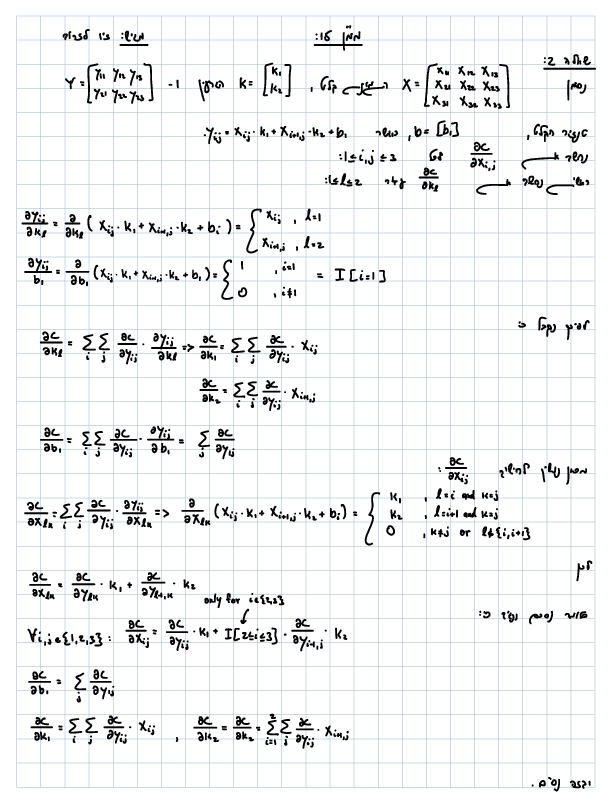

In [123]:
first_page = WImage(filename='./ZivLazarov-maman15-Q2.pdf[0]')
first_page

### Q3

#### Q3.a

In [15]:
import torchvision.transforms as T

In [16]:
cifar10_dataset = torchvision.datasets.CIFAR10(root='./cifar10',
                                              train=True,
                                              download=True,
                                              transform=T.PILToTensor())

100%|██████████| 170498071/170498071 [00:05<00:00, 31703159.10it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


In [17]:
cifar10_dataloader = DataLoader(cifar10_dataset, batch_size=64)

In [18]:
import matplotlib.pyplot as plt

In [19]:
img = next(iter(cifar10_dataloader))

In [20]:
img[0].shape, img[1]

(torch.Size([64, 3, 32, 32]),
 tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
         2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2,
         2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2]))

In [21]:
targets = np.array(cifar10_dataset.targets)

#### Q3.c

#### Plotting image from every class

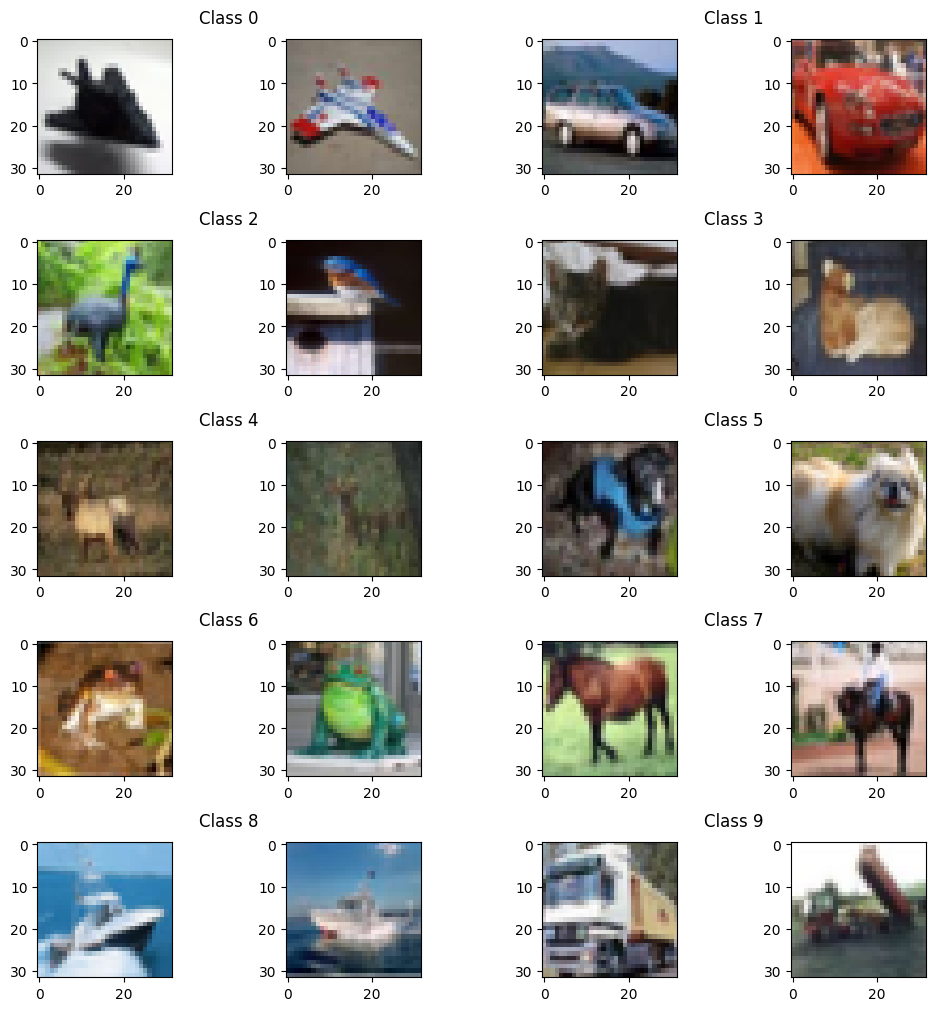

In [22]:
fig = plt.figure(constrained_layout=True, figsize=(10, 10))
# creating the subfigures
subfigs = fig.subfigures(5, 2)

for class_idx, subfig in enumerate(subfigs.flat):
    subfig.suptitle(f'Class {class_idx}')
    # getting the subfigure axes and plotting
    axes = subfig.subplots(1, 2)
    axes[0].imshow(cifar10_dataset.data[np.where(targets == class_idx)][0])
    axes[1].imshow(cifar10_dataset.data[np.where(targets == class_idx)][1])

#### Q3.d

#### Importing the ResNet18 pretrained model

In [23]:
import torchvision.models as models

In [24]:
resnet18 = models.resnet18(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 150MB/s]


In [25]:
for name, layer in resnet18.named_modules():
    print(f'{name}: {layer}')

: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)


#### Q3.e

#### Changing the output layer to match the CIFAR10 dataset we imported

In [26]:
resnet18._modules['fc'] = nn.Linear(in_features=512, out_features=10, bias=True)
resnet18._modules['fc1'] = nn.LogSoftmax(dim=1)

#### Defining relevant transformation w.r.t the training data ResNet18 trained on

In [27]:
resnet_transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda t: t.to(dtype=torch.float, device=device)),
    # no need to standardize the values to match the training values range - the ToTensor transformation handles that for us
    # as the shape of the data if H x W x C. same thing can be said for the movedim functionality
#     T.Lambda(lambda t: t/255.0),
    # T.Lambda(lambda t: torch.movedim(t, 2, 0)),
    T.Resize(224),
    # cropping to match the 224 dimensions of the training data
#     T.CenterCrop(224),
    T.Normalize(mean=torch.tensor([0.485, 0.456, 0.406]), std=torch.tensor([0.229, 0.224, 0.225])),
])

resnet_target_transform = T.Compose([
    T.Lambda(lambda tensor: torch.tensor(tensor).to(device=device))
])

In [28]:
cifar10_dataset = torchvision.datasets.CIFAR10(root='./cifar10',
                                              train=True,
                                              download=False,
                                              transform=resnet_transform,
                                               target_transform=resnet_target_transform)

cifar10_dataloader = DataLoader(cifar10_dataset, batch_size=256, shuffle=True)
cifar10_dataloader_full = DataLoader(cifar10_dataset, batch_size=len(cifar10_dataset.data))

In [29]:
list(resnet18.modules())[-2:]

[Linear(in_features=512, out_features=10, bias=True), LogSoftmax(dim=1)]

#### Q3.f

#### Defining only the last 2 layers parameters' as the trained parameters

In [30]:
parameters = [param for name, param in resnet18.named_parameters() if name.startswith('fc')]

#### Turning off the autograd system for the non-trainable parameters in the model

In [31]:
for name, param in resnet18.named_parameters():
    if not name.startswith('fc'):
        param.requires_grad = False

#### Optimizer and Loss function

In [32]:
lr = 0.001
optimizer = torch.optim.Adam(parameters, lr=lr, betas=(0.99, 0.99))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [33]:
loss = nn.CrossEntropyLoss()

In [34]:
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Tensors for the training process

In [35]:
epochs = 5

In [36]:
from tqdm import tqdm

In [37]:
@torch.no_grad
def evaluate_epoch(epoch_loss_values, epoch_num_correct_preds, dataset_size):
    epoch_accuracy = epoch_num_correct_preds / dataset_size
    epoch_loss = epoch_loss_values
    return epoch_loss, epoch_accuracy

In [38]:
@torch.no_grad
def evaluate_batch(batch_idx, model, loss_func, batch_X, batch_y):
    model.eval()

    batch_predictions = torch.argmax(model(batch_X), dim=1).to(dtype=torch.float, device=device)
    loss_value = loss_func(batch_predictions, batch_y.to(torch.float))
    num_correct_preds = (batch_predictions == batch_y).sum()
    return loss_value, num_correct_preds, batch_predictions

#### ResNet18 Training process and plots

In [39]:
def train(model, model_optimizer, model_scheduler, loss_func, epochs, dataloader, model_name, plot=True):
    dataset_size = len(dataloader.dataset.targets)
    epoch_loss = 0
    epoch_accuracy = 0
    
    train_loss, train_accuracy = torch.zeros(epochs).to(device), torch.zeros(epochs).to(device)
    
    start_time = time.time()
    for epoch in tqdm(range(epochs)):
        for batch_idx, (batch_X, batch_y) in enumerate(dataloader):
            model.train()
            
            model_optimizer.zero_grad()
            batch_output = model(batch_X)
            batch_loss = loss_func(batch_output, batch_y)
            batch_loss.backward()
            model_optimizer.step()
            
            # evaluating batch
            with torch.no_grad():
                model.eval()
                batch_preds = torch.argmax(batch_output, dim=1).to(device=device)
                batch_correct_preds = (batch_preds == batch_y).sum()
                
                epoch_accuracy += batch_correct_preds
                epoch_loss += batch_loss
                
        if model_scheduler:
            model_scheduler.step()
            print(f'Current lr: {model_scheduler.get_last_lr()}')
                
        train_loss[epoch], train_accuracy[epoch] = evaluate_epoch(epoch_loss, epoch_accuracy, dataset_size)
        
        epoch_loss = 0
        epoch_accuracy = 0
        
    end_time = time.time()
    total_time = end_time - start_time
    print(f'{model_name} CIFAR10 training time was {total_time} seconds.')
    
    if plot:
        fig, axes = plt.subplots(1, 2)
        axes[0].plot(torch.arange(epochs), train_accuracy.to('cpu').detach().numpy(), label='Accuracy')
        axes[0].set_title('Accuracy')
        axes[1].plot(torch.arange(epochs), torch.log(train_loss).to('cpu').detach().numpy(), label='Loss')
        axes[1].set_title('Loss')

        fig.tight_layout()

  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 20%|██        | 1/5 [00:47<03:11, 47.85s/it]

Current lr: [0.0009000000000000001]


 40%|████      | 2/5 [01:34<02:21, 47.03s/it]

Current lr: [0.0008100000000000001]


 60%|██████    | 3/5 [02:21<01:33, 46.95s/it]

Current lr: [0.000729]


 80%|████████  | 4/5 [03:07<00:46, 46.83s/it]

Current lr: [0.0006561000000000001]


100%|██████████| 5/5 [03:54<00:00, 46.87s/it]

Current lr: [0.00059049]
ResNet18 CIFAR10 training time was 234.3598165512085 seconds.


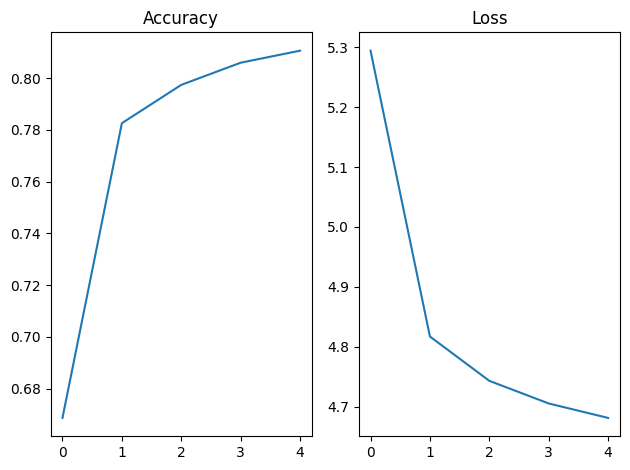

In [40]:
train(resnet18, optimizer, scheduler, loss, epochs, cifar10_dataloader, 'ResNet18')

In [41]:
if device == 'cuda':
    !nvidia-smi

Fri Jun 21 14:17:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0              43W / 250W |   3050MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

#### Creating the test data and evaluating the trained model

In [42]:
cifar10_test_dataset = torchvision.datasets.CIFAR10(root='./cifar10',
                                              train=False,
                                              download=True,
                                              transform=resnet_transform,
                                               target_transform=resnet_target_transform)

cifar10_test_dataloader = DataLoader(cifar10_test_dataset, batch_size=256)

Files already downloaded and verified


In [43]:
@torch.no_grad
def evaluate_test(model, loss_func, dataloader):
    model.eval()
    
    test_accuracy = 0
    test_loss = 0
    num_classes = len(np.unique(dataloader.dataset.targets))
    confusion_matrix = torch.zeros((num_classes, num_classes)).to(device)

    for batch_idx, (batch_X, batch_y) in enumerate(dataloader):
        batch_loss, batch_correct_preds, batch_predictions = evaluate_batch(batch_idx, model, loss_func, batch_X, batch_y)
        batch_predictions = batch_predictions.to(dtype=torch.int, device=device)
        test_loss += batch_loss
        test_accuracy += batch_correct_preds
        
        for i in range(len(batch_X)):
            label_idx = batch_y[i] - 1
            preds_idx = batch_predictions[i] - 1
            confusion_matrix[label_idx, preds_idx] += 1
    
    test_accuracy = test_accuracy / len(dataloader.dataset.data)
    
    return torch.log(test_loss), test_accuracy, confusion_matrix

In [44]:
test_loss, test_accuracy, confusion_matrix = evaluate_test(resnet18, loss, cifar10_test_dataloader)

In [45]:
import seaborn as sns

#### ResNet18 test metrics plot

Text(0.5, 1.0, 'Accuracy: 0.8014000058174133 | Loss (log): 12.62966537475586')

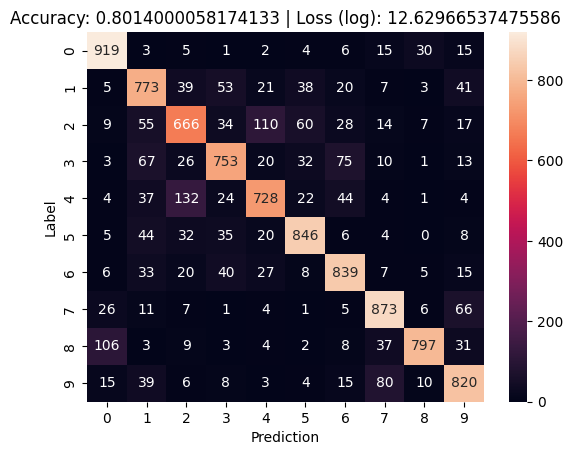

In [46]:
sns.heatmap(confusion_matrix.to('cpu').detach().numpy(), annot=True, fmt='.4g')
plt.ylabel('Label')
plt.xlabel('Prediction')
plt.title(f'Accuracy: {test_accuracy} | Loss (log): {test_loss}')

#### Q3.h

#### Getting the top 10 errors from the test evaluation stage

In [47]:
# a mask for nullifying the diagonal in the confusion matrix to get only errors
mask = torch.ones_like(confusion_matrix, dtype=torch.bool)
for i in range(len(mask)):
    mask[i, i] = 0

In [48]:
# topk returns the k largest elements/their indices in a given tensor
top10_errors_indices = torch.topk((confusion_matrix * mask).flatten(), 10).indices.reshape(-1, 1)

In [49]:
top10_errors_indices

tensor([[42],
        [24],
        [80],
        [97],
        [36],
        [31],
        [79],
        [25],
        [21],
        [13]], device='cuda:0')

In [50]:
# transforming it to (row, col) indices instead of a number in [0, 100) range
top10_errors_indices_transform = T.Lambda(lambda value: (value // 10, value % 10))

In [51]:
row_indices, col_indices = top10_errors_indices_transform(top10_errors_indices)

In [52]:
for i in range(10):
    print(f'Predicted: {col_indices[i].item()} - Actual: {row_indices[i].item()} - {confusion_matrix[row_indices[i], col_indices[i]].item()}')

Predicted: 2 - Actual: 4 - 132.0
Predicted: 4 - Actual: 2 - 110.0
Predicted: 0 - Actual: 8 - 106.0
Predicted: 7 - Actual: 9 - 80.0
Predicted: 6 - Actual: 3 - 75.0
Predicted: 1 - Actual: 3 - 67.0
Predicted: 9 - Actual: 7 - 66.0
Predicted: 5 - Actual: 2 - 60.0
Predicted: 1 - Actual: 2 - 55.0
Predicted: 3 - Actual: 1 - 53.0


#### Q3.i

In [53]:
test_targets = np.array(cifar10_test_dataset.targets)

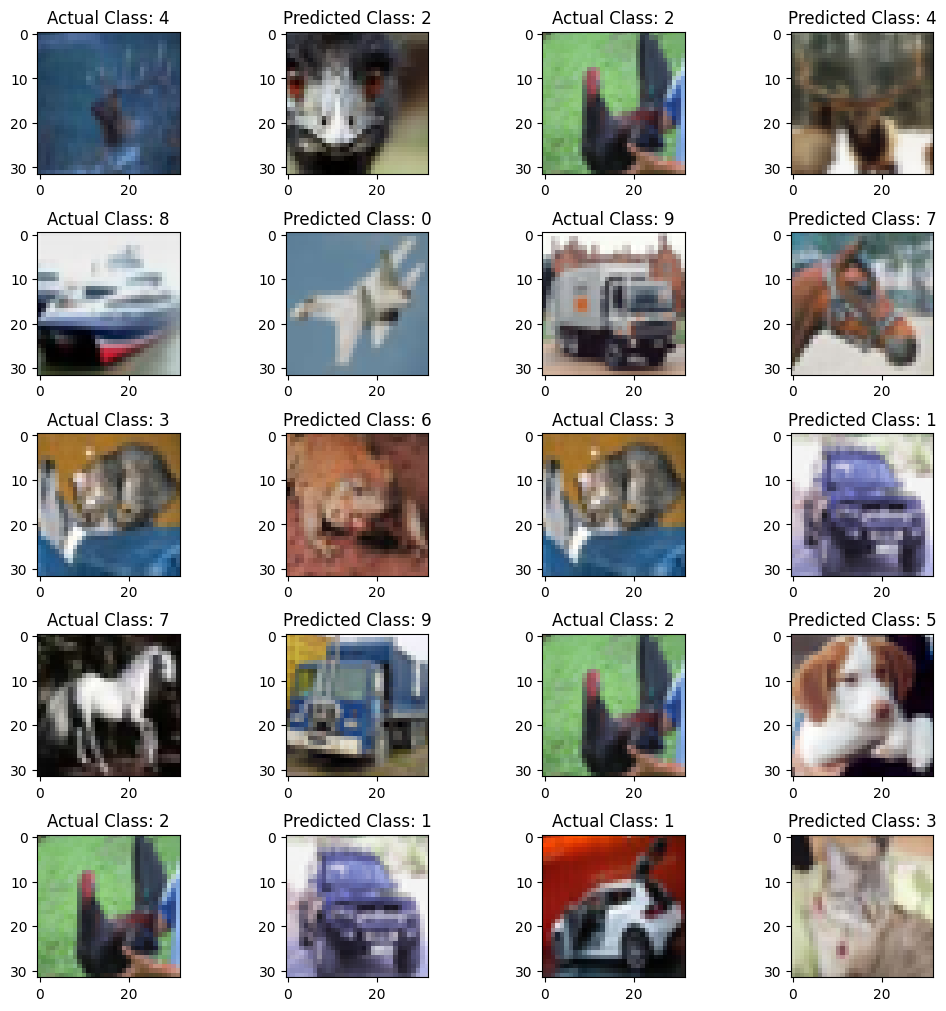

In [54]:
fig = plt.figure(constrained_layout=True, figsize=(10, 10))

# creating the subfigures
subfigs = fig.subfigures(5, 2)

for class_idx, subfig in enumerate(subfigs.flat):
    # getting the subfigure axes and plotting
    actual_idx = row_indices[class_idx].item()
    predicted_idx = col_indices[class_idx].item()
    axes = subfig.subplots(1, 2)
    axes[0].set_title(f'Actual Class: {actual_idx}')
    axes[0].imshow(cifar10_test_dataset.data[np.where(test_targets == actual_idx)][0].astype(np.uint8))
    axes[1].set_title(f'Predicted Class: {predicted_idx}')
    axes[1].imshow(cifar10_test_dataset.data[np.where(test_targets == predicted_idx)][1].astype(np.uint8))

In [55]:
if device != 'cpu':
    device_backend.empty_cache()

#### Q3.j

#### Creating a new model

In [56]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Defining our custom model

In [57]:
class ResNetModel(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        # setting 32 output channels for the first layers which will multiply every block
        out_channels = 32
        
        self.relu = nn.ReLU()
        
        # first block (non-residual)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

        # receives an image with 32 input and output channels
        self.block = nn.Sequential(
            # not adding bias as we have bias in the batchnorm layer
            nn.Conv2d(out_channels, out_channels, 3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            # same bias reason here
            nn.Conv2d(out_channels, out_channels, 3, padding='same', bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # needs to match the input channels and to divide the width/height dimensions by 2
        self.conv2 = nn.Conv2d(out_channels, out_channels, 1, stride=2, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # multiplying the output channels as we divided by 2 the number of pixels
        out_channels = out_channels * 2
        
        # first residual block
        self.first_res_block = nn.Sequential(
            # setting input channels as previous block's output channels and multiplying the output channels for this block
            nn.Conv2d(out_channels // 2, out_channels, 3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            # same bias reason here
            nn.Conv2d(out_channels, out_channels, 3, padding='same', bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        # first skip
        self.down_sample1 = nn.Sequential(
            nn.Conv2d(out_channels // 2, out_channels, 1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        out_channels = out_channels * 2
        
        self.second_res_block = nn.Sequential(            
            # setting input channels as previous block's output channels and multiplying the output channels for this block
            nn.Conv2d(out_channels // 2, out_channels, 3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            # same bias reason here
            nn.Conv2d(out_channels, out_channels, 3, padding='same', bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        # second skip
        self.down_sample2 = nn.Sequential(
            nn.Conv2d(out_channels // 2, out_channels, 1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        
        out_channels = out_channels * 2
        
        self.third_res_block = nn.Sequential(
            nn.Conv2d(out_channels // 2, out_channels, 3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding='same', bias=False),
            nn.BatchNorm2d(out_channels)
        )
        
        # third skip
        self.down_sample3 = nn.Sequential(
            nn.Conv2d(out_channels // 2, out_channels, 1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        # average pooling with the output layer of 10 classes
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(in_features=out_channels, out_features=10, bias=True)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, X):
        X0 = self.conv1(X)
        X0 = self.bn1(X0)
        X0 = self.relu(X0)
        X0 = self.maxpool(X0)
        
        # first block
        Y1_ = self.block(X0)
        Y1_1 = Y1_ + self.bn2(self.conv2(X0))
        Y1 = self.relu(Y1_1)
        
        # first residual block
        Y2_ = self.first_res_block(Y1)
        # downsampling
        Y2_2 = Y2_ + self.down_sample1(Y1)
        Y2 = self.relu(Y2_2)
        
        # second residual block
        Y3_ = self.second_res_block(Y2)
        # downsampling
        Y3_3 = Y3_ + self.down_sample2(Y2)
        Y3 = self.relu(Y3_3)
        
        # third residual block
        Y4_ = self.third_res_block(Y3)
        # downsampling
        Y4_4 = Y4_ + self.down_sample3(Y3)
        Y4 = self.relu(Y4_4)
        
        # adaptive pooling and fc
        Y = self.avgpool(Y4)
        # getting rid of empty dimensions
        Y = self.linear(Y.squeeze())
        Y = self.logsoftmax(Y)
        return Y

In [58]:
model = ResNetModel(in_channels=3)

#### Training all parameters in the model and not only the the linear layer

In [59]:
model_parameters = model.parameters()

In [60]:
model_optimizer = torch.optim.Adam(model_parameters, lr=lr, betas=(0.9, 0.99))
model_scheduler = torch.optim.lr_scheduler.ExponentialLR(model_optimizer, gamma=0.9)
model_loss = nn.CrossEntropyLoss()

In [61]:
model.to(device)

ResNetModel(
  (relu): ReLU()
  (conv1): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (block): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Conv2d(32, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (first_res_block): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1

In [62]:
print(f'Number of our model\'s parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')

Number of our model's parameters: 1233898


#### Emptying cache from GPU and invoking the garbage collector

In [63]:
import gc

In [64]:
gc.collect()
if device != 'cpu':
    device_backend.empty_cache()

#### Training our custom model

  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
 20%|██        | 1/5 [00:41<02:44, 41.23s/it]

Current lr: [0.0009000000000000001]


 40%|████      | 2/5 [01:22<02:02, 40.96s/it]

Current lr: [0.0008100000000000001]


 60%|██████    | 3/5 [02:02<01:21, 40.90s/it]

Current lr: [0.000729]


 80%|████████  | 4/5 [02:43<00:40, 40.85s/it]

Current lr: [0.0006561000000000001]


100%|██████████| 5/5 [03:24<00:00, 40.94s/it]

Current lr: [0.00059049]
Custom ResNet Model CIFAR10 training time was 204.69211769104004 seconds.


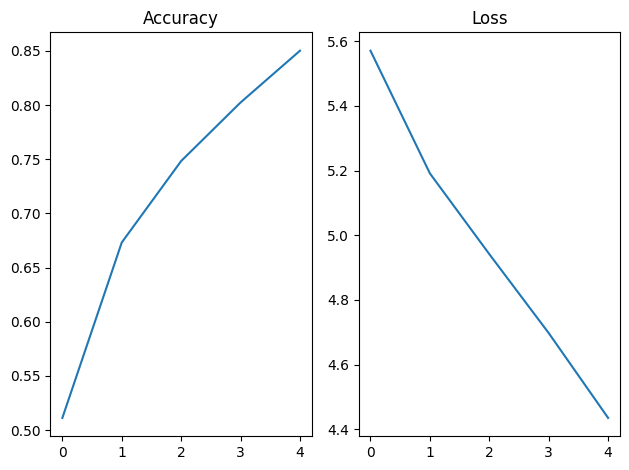

In [65]:
train(model, model_optimizer, model_scheduler, model_loss, epochs, cifar10_dataloader, 'Custom ResNet Model')

#### Evaluating it and plotting results

In [66]:
test_loss, test_accuracy, confusion_matrix = evaluate_test(model, model_loss, cifar10_test_dataloader)

Text(0.5, 1.0, 'Accuracy: 0.7317999601364136 | Loss (log): 12.65623950958252')

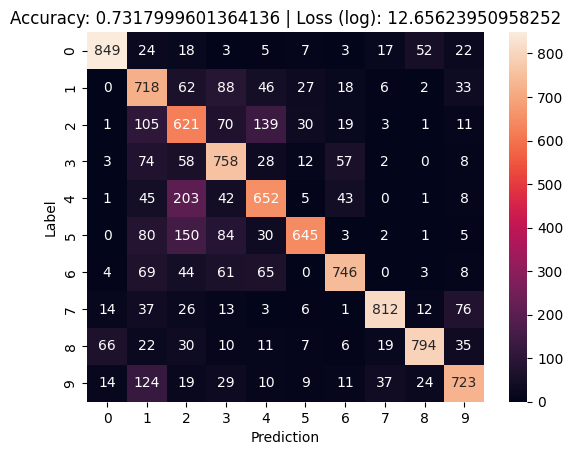

In [67]:
sns.heatmap(confusion_matrix.to('cpu').detach().numpy(), annot=True, fmt='.4g')
plt.ylabel('Label')
plt.xlabel('Prediction')
plt.title(f'Accuracy: {test_accuracy} | Loss (log): {test_loss}')

In [68]:
print(f'Number of our ResNet18 parameters: {sum(p.numel() for p in resnet18.parameters() if p.requires_grad)}')

Number of our ResNet18 parameters: 5130


In [69]:
model_scheduler.get_last_lr()

[0.00059049]